In [19]:
# Add this cell at the top of your notebook
import sys
import os

# Set the root folder as the working directory (if running from a subfolder)
sys.path.append(os.path.abspath("."))

# Import necessary modules
import torch
from torch.utils.data import DataLoader
from torchvision import transforms
from models.detector import RetinoblastomaDetector
from utils.dataset import load_dataset
from utils.evaluation import evaluate_model, plot_loss
from sklearn.metrics import (
    roc_auc_score, roc_curve, confusion_matrix, classification_report
)
import matplotlib.pyplot as plt
import seaborn as sns
import json


In [20]:
# Initialize the model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = RetinoblastomaDetector().to(device)
model.load_state_dict(torch.load("models/retinoblastoma_detector.pth"))
model.eval()

C:\Users\amirn\AppData\Local\Temp\ipykernel_12580\314417853.py:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("models/retinoblastoma_detec

RetinoblastomaDetector(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=200704, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=2, bias=True)
)

In [21]:
# Load the dataset
data_dir = "Training"
_, class_names = load_dataset(data_dir)

# Split dataset (same as in train.py)
from torch.utils.data import random_split
train_loader, _ = load_dataset(data_dir)
train_size = int(0.7 * len(train_loader.dataset))
test_size = len(train_loader.dataset) - train_size
_, test_dataset = random_split(train_loader.dataset, [train_size, test_size])

# Create a DataLoader for the test set
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)


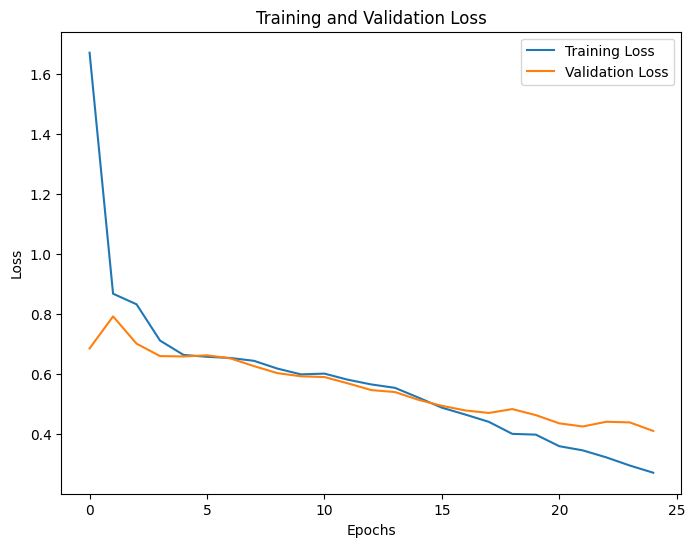

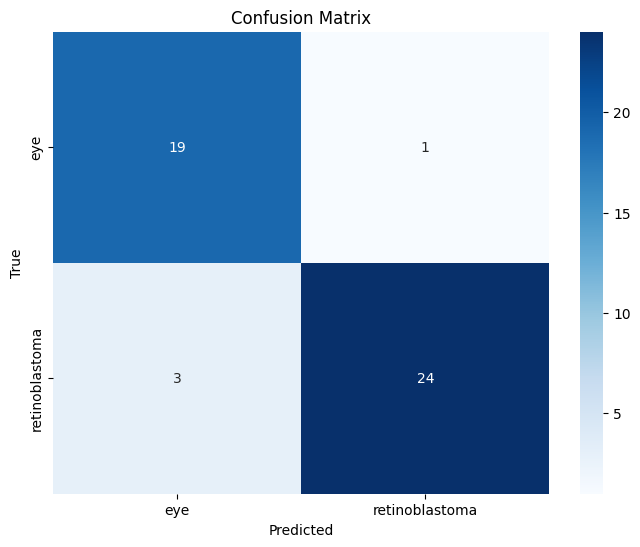


Classification Report:
                precision    recall  f1-score   support

           eye       0.86      0.95      0.90        20
retinoblastoma       0.96      0.89      0.92        27

      accuracy                           0.91        47
     macro avg       0.91      0.92      0.91        47
  weighted avg       0.92      0.91      0.92        47

ROC-AUC Score: 0.98


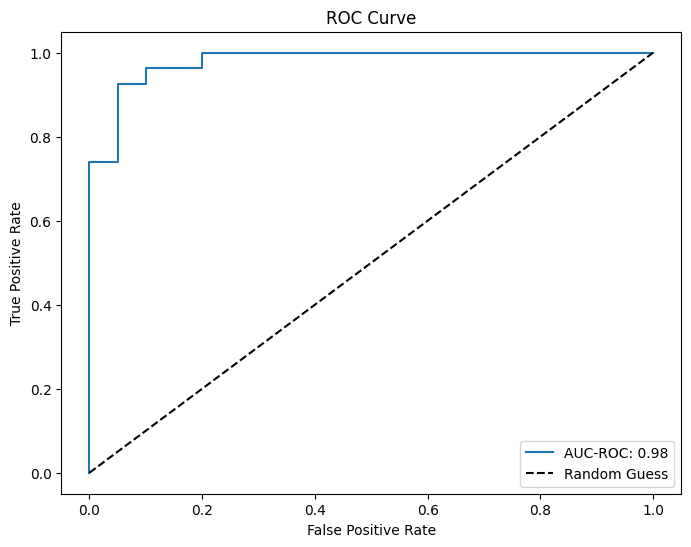

In [22]:
# Load the saved loss data
with open("models/losses.json", "r") as f:
    loss_data = json.load(f)

train_losses = loss_data["train_losses"]
validation_losses = loss_data["validation_losses"]

# Plot the loss curves
plt.figure(figsize=(8, 6))
plt.plot(train_losses, label="Training Loss")
plt.plot(validation_losses, label="Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training and Validation Loss")
plt.legend()
plt.show()

# Evaluate the model with metrics
y_true = []  # True labels
y_pred = []  # Predicted labels
y_probs = []  # Predicted probabilities for ROC-AUC

# Generate predictions and collect true labels
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        probs = torch.softmax(outputs, dim=1)[:, 1]  # Probabilities for the positive class
        preds = torch.argmax(outputs, dim=1)         # Predicted class labels

        y_probs.extend(probs.cpu().numpy())
        y_pred.extend(preds.cpu().numpy())
        y_true.extend(labels.cpu().numpy())

# Compute Confusion Matrix
cm = confusion_matrix(y_true, y_pred)

# Plot Confusion Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

# Classification Report
print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=class_names))

# Compute ROC-AUC
auc_roc = roc_auc_score(y_true, y_probs)
print(f"ROC-AUC Score: {auc_roc:.2f}")

# Plot the ROC Curve
fpr, tpr, _ = roc_curve(y_true, y_probs)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f"AUC-ROC: {auc_roc:.2f}")
plt.plot([0, 1], [0, 1], "k--", label="Random Guess")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.show()


In [32]:
# Predict a single image
from PIL import Image

# Define the transform for test images
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5])  # Normalize to match training preprocessing
])

# Specify the file path
image_path = "Training/retinoblastoma/retinoblastoma_64.jpg"  # Replace with your actual image path

# Check if the file exists
if not os.path.exists(image_path):
    print(f"Error: File not found at {image_path}. Please verify the file path.")
else:
    try:
        # Load and preprocess the image
        image = Image.open(image_path).convert("RGB")
        input_tensor = transform(image).unsqueeze(0).to(device)

        # Predict using the model
        model.eval()  # Ensure the model is in evaluation mode
        with torch.no_grad():  # Disable gradient calculation
            output = model(input_tensor)
            _, predicted = torch.max(output, 1)
            confidence = torch.softmax(output, 1).max().item()

        # Display the prediction results
        print(f"Predicted Class: {class_names[predicted.item()]}, Confidence: {confidence:.2%}")
    except Exception as e:
        print(f"An error occurred while processing the image: {e}")

Predicted Class: retinoblastoma, Confidence: 81.43%
